In [172]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import glob
import numpy as np
import seaborn as sns


import cvxopt as opt
from cvxopt import blas, solvers


Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['sqrt', 'matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Import the data 

In [56]:

pathName  =   '/Users/jiaweima/Desktop/Research/'
fileName  =  'wbpqlzv8hdd8xmip.csv'

In [57]:
df        = pd.read_csv(pathName + fileName )
df.head()

,PERMNO,SecInfoStartDt,SecInfoEndDt,SecurityNm,SecurityType,Ticker,DlyCalDt,DlyPrc,DlyRet
0,89730,2003-04-11,2004-06-09,ISHARES TRUST; ETFNONE; CONS,FUND,EEM,2003-04-11,99.70,NaN
1,89730,2003-04-11,2004-06-09,ISHARES TRUST; ETFNONE; CONS,FUND,EEM,2003-04-14,101.00,0.013039
2,89730,2003-04-11,2004-06-09,ISHARES TRUST; ETFNONE; CONS,FUND,EEM,2003-04-15,102.20,0.011881
3,89730,2003-04-11,2004-06-09,ISHARES TRUST; ETFNONE; CONS,FUND,EEM,2003-04-16,103.38,0.011546
4,89730,2003-04-11,2004-06-09,ISHARES TRUST; ETFNONE; CONS,FUND,EEM,2003-04-17,104.12,0.007158


In [58]:
# drop some PERMNO because these are stocks not ETFS with the same symbol

idxPERMNO = ~df['PERMNO'].isin([79754,75899])
df = df.loc[idxPERMNO,:].copy()

In [59]:
# list of names for ETFS
df_name = ["iShares Emerging Markets","iShares EAFE","iShares Japan", "ishares GS Commodities","iShares Gold","iShares REITs","iShares Global","SP500","R2000","Corporate Bonds","Bonds 1-3yr","Bonds 20y"]
df_sym  = ['EEM','EFA','EWJ','GSG','IAU','ICF','IOO','IVV','IWM','LQD','SHY','TLT']

In [60]:
pd.DataFrame([df_name,df_sym]).T

,0,1
0,iShares Emerging Markets,EEM
1,iShares EAFE,EFA
2,iShares Japan,EWJ
3,ishares GS Commodities,GSG
4,iShares Gold,IAU
5,iShares REITs,ICF
6,iShares Global,IOO
7,SP500,IVV
8,R2000,IWM
9,Corporate Bonds,LQD


In [61]:
# rotate the data to returns 
df_etf = pd.pivot_table(df, index = 'DlyCalDt', columns = 'Ticker', values = 'DlyRet')

In [62]:
# use days that have return data available

idxData = df_etf.index >= '2006-07-24'

df_etf = df_etf.loc[idxData,:].copy()

df_etf.head()

Ticker,EEM,EFA,EWJ,GSG,IAU,ICF,IOO,IVV,IWM,LQD,SHY,TLT
DlyCalDt,,,,,,,,,,,,
2006-07-24,0.044984,0.018130,0.018794,0.009137,-0.012449,0.017078,0.015527,0.017060,0.031910,0.000288,0.000000,-0.000586
2006-07-25,0.002664,-0.000312,0.007686,-0.009054,0.009987,0.004664,0.005902,0.003877,0.002468,-0.000768,-0.000251,-0.002932
2006-07-26,-0.004251,0.007031,-0.005339,0.007513,0.005025,0.005803,0.004516,0.001892,-0.002172,0.002115,0.001255,0.003646
2006-07-27,0.013767,0.006206,0.013804,0.010681,0.015484,-0.002192,0.000449,-0.001337,-0.009579,-0.001535,0.000501,-0.001523
2006-07-28,0.021476,0.020046,0.027231,-0.011964,0.003018,0.015433,0.014376,0.010161,0.020955,0.003842,0.001253,0.005750


In [63]:
df_etf.tail()

Ticker,EEM,EFA,EWJ,GSG,IAU,ICF,IOO,IVV,IWM,LQD,SHY,TLT
DlyCalDt,,,,,,,,,,,,
2022-12-23,-0.001321,0.003503,0.000731,0.018349,0.003530,0.008992,0.003907,0.005201,0.004551,-0.003073,-0.000492,-0.014660
2022-12-27,0.014815,0.001518,-0.004565,0.007112,0.007916,-0.000546,-0.003425,-0.003848,-0.006709,-0.012890,-0.001353,-0.019773
2022-12-28,-0.014599,-0.010608,-0.011922,-0.009416,-0.004654,-0.015105,-0.012027,-0.012138,-0.015529,-0.003123,0.000000,-0.005892
2022-12-29,0.016667,0.015776,0.018563,-0.002376,0.006429,0.022173,0.016917,0.017307,0.025333,0.007119,0.000739,0.011351
2022-12-30,-0.013791,-0.010253,-0.007837,0.011434,0.004355,-0.008677,-0.004198,-0.002078,-0.002802,-0.006315,-0.001230,-0.011124


In [64]:

# df.dropna(inplace=True)  would not use this function - need to understand why data is missing
df_etf.dtypes  #check the data types

Ticker
EEM    float64
EFA    float64
EWJ    float64
GSG    float64
IAU    float64
ICF    float64
IOO    float64
IVV    float64
IWM    float64
LQD    float64
SHY    float64
TLT    float64
dtype: object

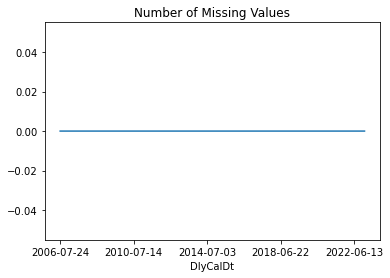

In [65]:
# check for missing data
df_etf_miss = df_etf.isna().sum(axis = 1).plot(title = 'Number of Missing Values') 

# Create some summary statistics for risk parity portfolio
 - statsitics
 - distribution characteristics
 - returns, risk, Sharpe
 - cumulative returns

In [66]:
bs = df_etf.describe()
bs

Ticker,EEM,EFA,EWJ,GSG,IAU,ICF,IOO,IVV,IWM,LQD,SHY,TLT
count,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000,4140.000000
mean,0.000309,0.000230,0.000162,-0.000086,0.000311,0.000409,0.000349,0.000432,0.000413,0.000175,0.000062,0.000201
std,0.018518,0.014235,0.013148,0.015243,0.011180,0.020538,0.012978,0.012671,0.015874,0.005625,0.000881,0.009474
min,-0.161662,-0.111632,-0.104077,-0.120811,-0.088459,-0.217789,-0.108019,-0.115743,-0.132669,-0.091111,-0.006566,-0.066683
25%,-0.008132,-0.005506,-0.006039,-0.007780,-0.005003,-0.006923,-0.004840,-0.004008,-0.007016,-0.002024,-0.000353,-0.005302
50%,0.000904,0.000699,0.000516,0.000580,0.000621,0.000844,0.000770,0.000754,0.001022,0.000423,0.000000,0.000476
75%,0.008794,0.006673,0.006701,0.007976,0.006088,0.007880,0.006245,0.005974,0.008376,0.002546,0.000462,0.005658
max,0.227699,0.158876,0.171817,0.076193,0.116987,0.181701,0.120479,0.110993,0.091491,0.097677,0.007119,0.075196


<AxesSubplot:>

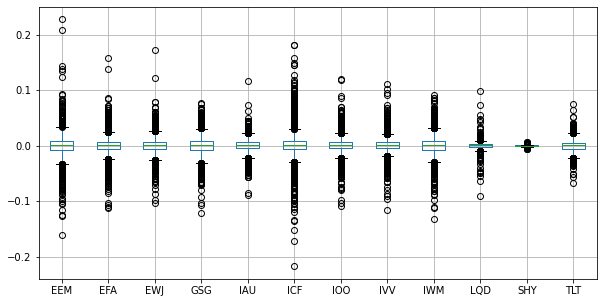

In [67]:
df_etf.boxplot(figsize =(10,5))

In [68]:
# create a function

def calcStats(x):
    # x is a dataframe of daily returns
    ReturnAnn = x.mean()*252
    VolAnn    = x.std()*np.sqrt(252)
    Sharpe    = ReturnAnn/VolAnn
    AnnStats  = pd.DataFrame([ReturnAnn, VolAnn, Sharpe]).T
    AnnStats.columns = ['Return', 'Vol', 'Sharpe']
    return AnnStats

In [69]:
calcStats(df_etf)

,Return,Vol,Sharpe
Ticker,,,
EEM,0.077786,0.293970,0.264607
EFA,0.058021,0.225976,0.256757
EWJ,0.040796,0.208714,0.195466
GSG,-0.021768,0.241982,-0.089958
IAU,0.078366,0.177481,0.441547
ICF,0.103144,0.326035,0.316358
IOO,0.087977,0.206023,0.427025
IVV,0.108864,0.201146,0.541220
IWM,0.104119,0.251992,0.413182


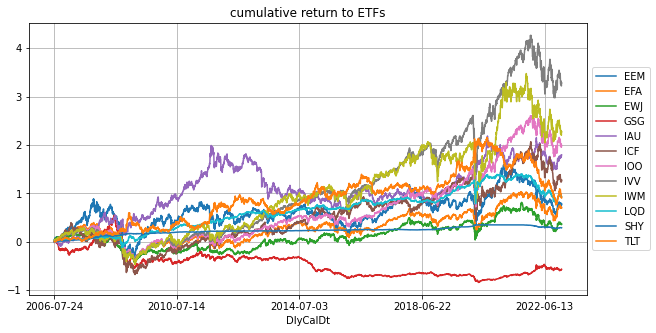

In [70]:
# calculate cumulative returns
df_etf_cumret = (df_etf+1).cumprod()-1
ax = df_etf_cumret.plot(figsize = (10,5))
plt.grid()
plt.title('cumulative return to ETFs')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [71]:
# calculate correlations
etfCorr = df_etf.corr()
etfCorr

Ticker,EEM,EFA,EWJ,GSG,IAU,ICF,IOO,IVV,IWM,LQD,SHY,TLT
Ticker,,,,,,,,,,,,
EEM,1.000000,0.881205,0.757616,0.443944,0.150870,0.665442,0.858912,0.835292,0.776102,0.161495,-0.284079,-0.322591
EFA,0.881205,1.000000,0.862145,0.450904,0.137132,0.687132,0.948484,0.895112,0.826386,0.203663,-0.253535,-0.356037
EWJ,0.757616,0.862145,1.000000,0.338422,0.085515,0.579120,0.803364,0.771917,0.708871,0.195457,-0.190588,-0.258844
GSG,0.443944,0.450904,0.338422,1.000000,0.275000,0.270970,0.439336,0.409684,0.392154,0.066993,-0.132134,-0.256583
IAU,0.150870,0.137132,0.085515,0.275000,1.000000,0.045366,0.092064,0.044180,0.038930,0.145303,0.188456,0.161125
ICF,0.665442,0.687132,0.579120,0.270970,0.045366,1.000000,0.713022,0.757936,0.749571,0.146140,-0.199542,-0.213944
IOO,0.858912,0.948484,0.803364,0.439336,0.092064,0.713022,1.000000,0.963489,0.858971,0.171720,-0.277095,-0.379410
IVV,0.835292,0.895112,0.771917,0.409684,0.044180,0.757936,0.963489,1.000000,0.909573,0.166411,-0.287589,-0.376400
IWM,0.776102,0.826386,0.708871,0.392154,0.038930,0.749571,0.858971,0.909573,1.000000,0.137820,-0.260405,-0.362907


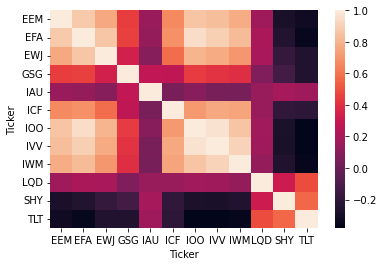

In [72]:
sns.heatmap(etfCorr);

## Create rolling volatility
using the previous rolling 1 year returns


In [73]:
# create a data structure for the data (keep orginal data in df)
df_vol1yr = df_etf.copy() 

In [74]:
volPeriod = 252

for i in df_sym:
    df_vol1yr[i] = df_vol1yr[i].rolling(volPeriod).std() * sqrt(252)


In [75]:

# remove the NAs
idxRmNAs = df_vol1yr.isna().sum(axis=1)
idxRmNAs = idxRmNAs == 0
df_vol1yr = df_vol1yr.loc[idxRmNAs,:]

In [76]:
print(df_vol1yr.head())
print(df_vol1yr.tail())
#df.dropna(inplace=True)  % only want to drop NAs where it makes sense

Ticker           EEM       EFA       EWJ       GSG       IAU       ICF  \
DlyCalDt                                                                 
2007-07-24  0.221146  0.127860  0.138623  0.197887  0.170084  0.192272   
2007-07-25  0.216910  0.126775  0.137416  0.198225  0.169885  0.191786   
2007-07-26  0.222528  0.131339  0.138436  0.198058  0.170616  0.193024   
2007-07-27  0.223149  0.132025  0.138689  0.198130  0.170574  0.195779   
2007-07-30  0.224995  0.132998  0.139015  0.197819  0.169934  0.196678   

Ticker           IOO       IVV       IWM       LQD       SHY       TLT  
DlyCalDt                                                                
2007-07-24  0.109905  0.102245  0.160717  0.040620  0.012360  0.076792  
2007-07-25  0.108931  0.100952  0.157728  0.040624  0.012371  0.076807  
2007-07-26  0.112223  0.103538  0.160267  0.040678  0.012551  0.077166  
2007-07-27  0.113233  0.105625  0.162021  0.040815  0.012540  0.077136  
2007-07-30  0.113508  0.106624  0.162574  0

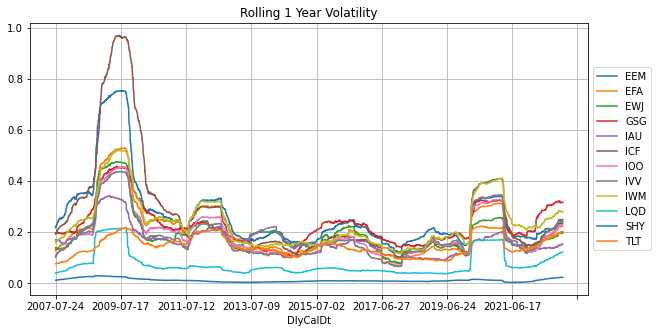

In [77]:

ax = df_vol1yr.plot(figsize = (10,5))
plt.grid()
plt.title('Rolling 1 Year Volatility')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [78]:
#  try different volatility measures: target cvol 10%, 5%, 15%

In [79]:
portfolio_vol = 0.10
target_vol = portfolio_vol/ len(df_sym)
print("Target Vol", target_vol)

Target Vol 0.008333333333333333


 With risk parity, we target a specific level of risk or return and split the risk equally across all asset classes. For this example, we are going to use a 10% annualized volatility target. 

In [80]:
# determine the weights of the portfolio
df_portfolio = target_vol / df_vol1yr 

In [81]:
df_portfolio.head()

Ticker,EEM,EFA,EWJ,GSG,IAU,ICF,IOO,IVV,IWM,LQD,SHY,TLT
DlyCalDt,,,,,,,,,,,,
2007-07-24,0.037683,0.065176,0.060115,0.042112,0.048995,0.043341,0.075823,0.081504,0.051851,0.205155,0.674224,0.108518
2007-07-25,0.038418,0.065733,0.060643,0.042040,0.049053,0.043451,0.076501,0.082548,0.052834,0.205135,0.673639,0.108497
2007-07-26,0.037449,0.063449,0.060196,0.042075,0.048843,0.043172,0.074257,0.080486,0.051996,0.204859,0.663970,0.107992
2007-07-27,0.037344,0.063120,0.060086,0.042060,0.048855,0.042565,0.073595,0.078896,0.051434,0.204173,0.664533,0.108034
2007-07-30,0.037038,0.062657,0.059946,0.042126,0.049039,0.042370,0.073417,0.078156,0.051259,0.204237,0.660323,0.107973


In [82]:
chk_wgts = df_portfolio.sum(axis = 1)


# interesting the weights are sometimes greater or less than 1. 

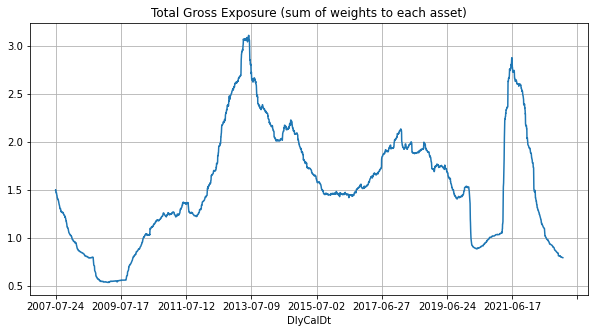

In [83]:
chk_wgts.plot(figsize = (10,5), title = "Total Gross Exposure (sum of weights to each asset)")
plt.grid()

In [84]:
print(df_etf.shape)
print(df_portfolio.shape)
# the difference in the size is related to the dates

#match the sizes
idxMatch = df_etf.index.isin(df_portfolio.index)
df_etf1  = df_etf.loc[idxMatch,:].copy()

(4140, 12)
(3889, 12)


In [85]:
#
# calculate the returns to the portfolio
df_return = df_etf1.copy()

for i in df_sym:
    df_return[i] = df_etf1[i] * df_portfolio[i]

    
# all the portfolio return back to the returns matrix
df_etf1['RiskParityVol1y10p']  =  df_return.sum(axis =1)

In [86]:
# compare the returns
df_etf1 = calcStats(df_etf1)

In [87]:
df_etf1

,Return,Vol,Sharpe
Ticker,,,
EEM,0.049720,0.298116,0.166779
EFA,0.041960,0.230882,0.181740
EWJ,0.033229,0.212439,0.156415
GSG,-0.016912,0.244575,-0.069147
IAU,0.076889,0.177948,0.432087
ICF,0.102603,0.332861,0.308246
IOO,0.076501,0.210758,0.362979
IVV,0.100314,0.205950,0.487078
IWM,0.095186,0.256840,0.370606


In [88]:
# redo the steps above and use target vol=5%
portfolio_vol = 0.05
target_vol = portfolio_vol/ len(df_sym)
print("Target Vol", target_vol)

Target Vol 0.004166666666666667


In [89]:
df_portfolio = target_vol / df_vol1yr

In [90]:
idxMatch = df_etf.index.isin(df_portfolio.index)
df_etf2  = df_etf.loc[idxMatch,:].copy()

In [91]:
df_return = df_etf2.copy()

for i in df_sym:
    df_return[i] = df_etf2[i] * df_portfolio[i]

df_etf2['RiskParityVol1y10p']  =  df_return.sum(axis =1)

In [92]:
df_etf2 = calcStats(df_etf2)
df_etf2

,Return,Vol,Sharpe
Ticker,,,
EEM,0.049720,0.298116,0.166779
EFA,0.041960,0.230882,0.181740
EWJ,0.033229,0.212439,0.156415
GSG,-0.016912,0.244575,-0.069147
IAU,0.076889,0.177948,0.432087
ICF,0.102603,0.332861,0.308246
IOO,0.076501,0.210758,0.362979
IVV,0.100314,0.205950,0.487078
IWM,0.095186,0.256840,0.370606


In [93]:
# redo the steps above and use target vol=15%
portfolio_vol = 0.15
target_vol = portfolio_vol/ len(df_sym)
print("Target Vol", target_vol)

Target Vol 0.012499999999999999


In [94]:
df_portfolio = target_vol / df_vol1yr

In [95]:
idxMatch = df_etf.index.isin(df_portfolio.index)
df_etf3  = df_etf.loc[idxMatch,:].copy()

In [96]:
df_return = df_etf3.copy()

for i in df_sym:
    df_return[i] = df_etf3[i] * df_portfolio[i]

df_etf3['RiskParityVol1y10p']  =  df_return.sum(axis =1)

In [97]:
df_etf3 = calcStats(df_etf3)
df_etf3

,Return,Vol,Sharpe
Ticker,,,
EEM,0.049720,0.298116,0.166779
EFA,0.041960,0.230882,0.181740
EWJ,0.033229,0.212439,0.156415
GSG,-0.016912,0.244575,-0.069147
IAU,0.076889,0.177948,0.432087
ICF,0.102603,0.332861,0.308246
IOO,0.076501,0.210758,0.362979
IVV,0.100314,0.205950,0.487078
IWM,0.095186,0.256840,0.370606


In [98]:
#create a single df and compare return, vol, and sharpe ratios for three portfolios
tv_10 =df_etf1.iloc[12]
tv_5 = df_etf2.iloc[12]
tv_15 = df_etf3.iloc[12]
df_diffvol = pd.concat([tv_10,tv_5,tv_15], join="inner",axis=1, keys=["Target Vol=10%","Target Vol=5%","Target Vol=15%"])
df_diffvol

,Target Vol=10%,Target Vol=5%,Target Vol=15%
Return,0.035486,0.017743,0.053229
Vol,0.062431,0.031216,0.093647
Sharpe,0.568400,0.568400,0.568400


In [99]:
## Classic Min Var Portfolio

In [100]:
#calculate covariance

df_cov = pd.DataFrame(df_etf.cov())
df_cov

Ticker,EEM,EFA,EWJ,GSG,IAU,ICF,IOO,IVV,IWM,LQD,SHY,TLT
Ticker,,,,,,,,,,,,
EEM,0.000343,0.000232,0.000184,0.000125,0.000031,0.000253,0.000206,0.000196,0.000228,0.000017,-4.633443e-06,-0.000057
EFA,0.000232,0.000203,0.000161,0.000098,0.000022,0.000201,0.000175,0.000161,0.000187,0.000016,-3.178795e-06,-0.000048
EWJ,0.000184,0.000161,0.000173,0.000068,0.000013,0.000156,0.000137,0.000129,0.000148,0.000014,-2.207042e-06,-0.000032
GSG,0.000125,0.000098,0.000068,0.000232,0.000047,0.000085,0.000087,0.000079,0.000095,0.000006,-1.774036e-06,-0.000037
IAU,0.000031,0.000022,0.000013,0.000047,0.000125,0.000010,0.000013,0.000006,0.000007,0.000009,1.855777e-06,0.000017
ICF,0.000253,0.000201,0.000156,0.000085,0.000010,0.000422,0.000190,0.000197,0.000244,0.000017,-3.609621e-06,-0.000042
IOO,0.000206,0.000175,0.000137,0.000087,0.000013,0.000190,0.000168,0.000158,0.000177,0.000013,-3.167428e-06,-0.000047
IVV,0.000196,0.000161,0.000129,0.000079,0.000006,0.000197,0.000158,0.000161,0.000183,0.000012,-3.209558e-06,-0.000045
IWM,0.000228,0.000187,0.000148,0.000095,0.000007,0.000244,0.000177,0.000183,0.000252,0.000012,-3.640821e-06,-0.000055


In [101]:
def portfolio_returns(weights):
    return (np.sum(df_etf.mean() * weights)) * 252

In [102]:
def portfolio_sd(weights):
    return np.sqrt(np.transpose(weights) @ (df_etf.cov() * 252) @ weights)

In [103]:
#define the function for calculating weights
def weightofmvp(COV):
    c_1 = np.linalg.inv(COV)
    u_1 = np.array([1,1,1,1,1,1,1,1,1,1,1,1])
    m = np.array(df_etf.mean())
    u = u_1.T
    Upper = np.matmul(u,c_1)
    Lower1 = np.matmul(u,c_1)
    Lower = np.matmul(Lower1,u_1)
    W_mvp = Upper/Lower
    W_mvp_1 = W_mvp.T
    return W_mvp

In [104]:
print("weights are",weightofmvp(df_cov))

weights are [ 1.03916117e-02 -6.88153495e-03 -5.99951569e-04  7.55295146e-04
 -7.17963066e-03  4.82567544e-04 -5.07891846e-03  2.03812142e-02
 -6.45576774e-03 -5.81134638e-03  1.03778462e+00 -3.77881631e-02]


In [105]:
print("portfolio return is",portfolio_returns(weightofmvp(df_cov)))
print("portfolio standard deviation is",portfolio_sd(weightofmvp(df_cov)))


portfolio return is 0.014997495331696002
portfolio standard deviation is 0.011802819809592451


In [106]:
portfolio_sharpe=portfolio_returns(weightofmvp(df_cov))/portfolio_sd(weightofmvp(df_cov))
print("portfolio Sharpe ratio is", portfolio_sharpe)

portfolio Sharpe ratio is 1.2706705324355758


In [107]:
cov_matrix = pd.DataFrame.cov(df_etf)
cov_matrix

Ticker,EEM,EFA,EWJ,GSG,IAU,ICF,IOO,IVV,IWM,LQD,SHY,TLT
Ticker,,,,,,,,,,,,
EEM,0.000343,0.000232,0.000184,0.000125,0.000031,0.000253,0.000206,0.000196,0.000228,0.000017,-4.633443e-06,-0.000057
EFA,0.000232,0.000203,0.000161,0.000098,0.000022,0.000201,0.000175,0.000161,0.000187,0.000016,-3.178795e-06,-0.000048
EWJ,0.000184,0.000161,0.000173,0.000068,0.000013,0.000156,0.000137,0.000129,0.000148,0.000014,-2.207042e-06,-0.000032
GSG,0.000125,0.000098,0.000068,0.000232,0.000047,0.000085,0.000087,0.000079,0.000095,0.000006,-1.774036e-06,-0.000037
IAU,0.000031,0.000022,0.000013,0.000047,0.000125,0.000010,0.000013,0.000006,0.000007,0.000009,1.855777e-06,0.000017
ICF,0.000253,0.000201,0.000156,0.000085,0.000010,0.000422,0.000190,0.000197,0.000244,0.000017,-3.609621e-06,-0.000042
IOO,0.000206,0.000175,0.000137,0.000087,0.000013,0.000190,0.000168,0.000158,0.000177,0.000013,-3.167428e-06,-0.000047
IVV,0.000196,0.000161,0.000129,0.000079,0.000006,0.000197,0.000158,0.000161,0.000183,0.000012,-3.209558e-06,-0.000045
IWM,0.000228,0.000187,0.000148,0.000095,0.000007,0.000244,0.000177,0.000183,0.000252,0.000012,-3.640821e-06,-0.000055


Text(0, 0.5, 'returns')

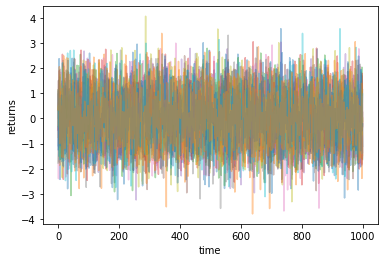

In [111]:
#plotting efficient frontier

np.random.seed(123)
# Calculate expected returns and covariance matrix from daily returns
expected_returns = df_etf.mean()


# Number of assets
n_assets = len(expected_returns)

#Number of observations
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [122]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)
rand_weights(n_assets)

array([0.11996081, 0.06979421, 0.01059849, 0.03760933, 0.14681514,
       0.08917257, 0.13507856, 0.11581577, 0.09750203, 0.00254353,
       0.04712989, 0.12797966])

In [123]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [127]:
n_portfolios = 1000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range (n_portfolios)
])

Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

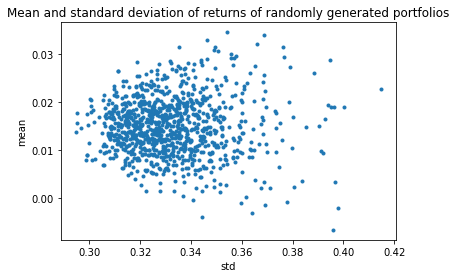

In [130]:
plt.plot(stds, means, 'o', markersize=3)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [136]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)



     pcost       dcost       gap    pres   dres
 0: -2.4011e-02 -1.0595e+00  1e+00  0e+00  4e+00
 1: -2.5538e-02 -6.8749e-02  4e-02  6e-17  2e-01
 2: -4.1812e-02 -5.0822e-02  9e-03  7e-17  7e-17
 3: -4.5031e-02 -4.5713e-02  7e-04  2e-16  4e-17
 4: -4.5422e-02 -4.5449e-02  3e-05  2e-16  5e-17
 5: -4.5436e-02 -4.5436e-02  3e-07  6e-17  2e-17
 6: -4.5436e-02 -4.5436e-02  3e-09  8e-17  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.3278e-02 -1.0586e+00  1e+00  2e-16  4e+00
 1: -2.4775e-02 -6.7837e-02  4e-02  6e-17  2e-01
 2: -4.0127e-02 -4.8810e-02  9e-03  8e-17  4e-17
 3: -4.3184e-02 -4.3832e-02  6e-04  8e-17  5e-17
 4: -4.3569e-02 -4.3593e-02  2e-05  1e-16  5e-17
 5: -4.3589e-02 -4.3590e-02  3e-07  8e-17  2e-17
 6: -4.3590e-02 -4.3590e-02  3e-09  8e-17  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.2465e-02 -1.0577e+00  1e+00  0e+00  4e+00
 1: -2.3928e-02 -6.6822e-02  4e-02  5e-17  2e-01
 2: -3.8351e-02 -4.6669e

 2:  1.4794e-01  1.4770e-01  2e-04  1e-16  8e-04
 3:  1.4794e-01  1.4793e-01  2e-06  4e-17  8e-06
 4:  1.4794e-01  1.4794e-01  2e-08  5e-17  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.6834e-01 -8.5185e-01  1e+00  1e-16  4e+00
 1:  1.6825e-01  1.4869e-01  2e-02  6e-17  7e-02
 2:  1.6822e-01  1.6801e-01  2e-04  5e-17  8e-04
 3:  1.6822e-01  1.6822e-01  2e-06  6e-17  8e-06
 4:  1.6822e-01  1.6822e-01  2e-08  4e-17  8e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9103e-01 -8.2861e-01  1e+00  1e-16  4e+00
 1:  1.9096e-01  1.7228e-01  2e-02  7e-17  7e-02
 2:  1.9094e-01  1.9074e-01  2e-04  5e-17  7e-04
 3:  1.9094e-01  1.9093e-01  2e-06  3e-17  7e-06
 4:  1.9094e-01  1.9094e-01  2e-08  5e-17  7e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1646e-01 -8.0267e-01  1e+00  0e+00  4e+00
 1:  2.1640e-01  1.9856e-01  2e-02  5e-17  7e-02
 2:  2.1638e-01  2.1619e-01  2e-04  2e-16  7e-04


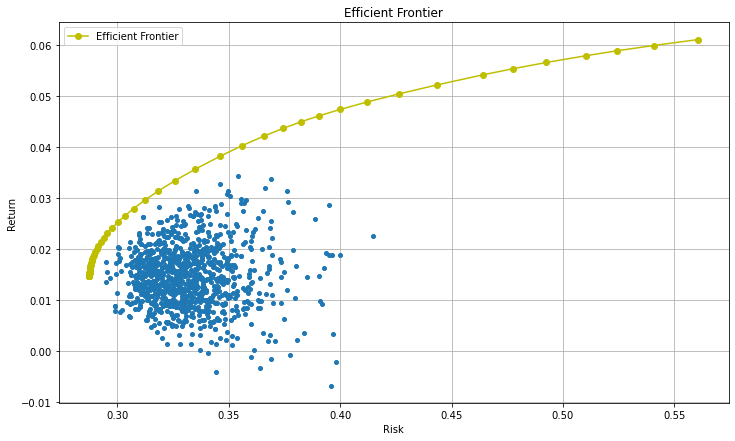

In [147]:
plt.figure(figsize=(12, 7))
plt.plot(stds, means, 'o', markersize=4)
plt.ylabel('Return')
plt.xlabel('Risk')
plt.plot(risks, returns, 'y-o',label='Efficient Frontier')
plt.title('Efficient Frontier')
plt.grid(True)
plt.legend()
plt.show()

In [148]:
#Mean Variance Portfolio




# Calculate expected returns and covariance matrix
expected_returns = df_etf.mean()
covariance_matrix = cov_matrix

# Define portfolio optimization function
def optimize_portfolio(expected_returns, covariance_matrix, risk_free_rate=0.0):
    """
    Optimize portfolio allocation using mean-variance approach.
    Inputs:
        - expected_returns: Series of expected returns for each asset
        - covariance_matrix: Covariance matrix of returns for all assets
        - risk_free_rate: Risk-free rate for calculating Sharpe ratio (default: 0.0)
    Outputs:
        - weights: Series of optimal asset weights
        - portfolio_return: Portfolio expected return
        - portfolio_volatility: Portfolio volatility (standard deviation)
        - sharpe_ratio: Portfolio Sharpe ratio
    """
    n_assets = len(expected_returns)
    initial_weights = np.ones(n_assets) / n_assets  # Equal weights initially

    # Define objective function for portfolio optimization
    def objective_function(weights):
        portfolio_return = np.sum(expected_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio  # Maximize Sharpe ratio, hence the negative sign

    # Define constraints for portfolio optimization
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Constraint: sum of weights equals 1
    bounds = tuple((0, 1) for _ in range(n_assets))  # Bounds: 0 <= weight <= 1 for all assets

    # Optimize portfolio allocation using scipy.optimize
    from scipy.optimize import minimize
    result = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    weights = pd.Series(result.x, index=expected_returns.index)
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return weights, portfolio_return, portfolio_volatility, sharpe_ratio

# Call portfolio optimization function
weights, portfolio_return, portfolio_volatility, sharpe_ratio = optimize_portfolio(expected_returns, covariance_matrix)

# Print results
print("Optimal Asset Weights:\n", weights)
print("Portfolio Expected Return:", portfolio_return)
print("Portfolio Volatility (Standard Deviation):", portfolio_volatility)
print("Sharpe Ratio:", sharpe_ratio)



Optimal Asset Weights:
 Ticker
EEM    2.630435e-15
EFA    2.714015e-15
EWJ    2.646771e-15
GSG    3.862261e-15
IAU    7.997215e-03
ICF    0.000000e+00
IOO    2.682687e-16
IVV    4.490773e-02
IWM    2.584879e-16
LQD    7.790218e-15
SHY    9.470951e-01
TLT    0.000000e+00
dtype: float64
Portfolio Expected Return: 8.061318378831643e-05
Portfolio Volatility (Standard Deviation): 0.0008872545406131106
Sharpe Ratio: 0.09085688502942021


In [176]:
##RISK PARITY WITH LEVERAGE
# calculate return, std, mdd
retMean = df_etf.mean()
retStd = df_etf.std()
sharpe = retMean / retStd * np.sqrt(252)

Roll_Max = df_etf.rolling(window, min_periods=1).max()
Daily_Drawdown = df_etf/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

#mdd = df_etf.calc_max_drawdown().abs()
perf= df_etf.calc_stats()

NameError: name 'window' is not defined

AttributeError: 'DataFrame' object has no attribute 'calc_stats'

In [171]:

# mdd leverage simulation (without considering leverage cost)
finlab_strategy_mean = mdd.mean()
mdd['Final Portfolio'] = abs(perf.max_drawdown)
mdd['Final Portfolio X 1.25'] = abs(perf.max_drawdown)*1.25
mdd['Final Portfolio X 1.5'] = abs(perf.max_drawdown)*1.5
mdd['Final Portfolio X 1.75'] = abs(perf.max_drawdown)*1.75
mdd['mean'] = finlab_strategy_mean
mdd['mean X 1.25'] = finlab_strategy_mean*1.25
mdd['mean X 1.5'] = finlab_strategy_mean*1.5
mdd['mean X 1.75'] = finlab_strategy_mean*1.75

# ========================== plot scatter chart (dot with label beside) ===========================
plt.figure(figsize=(10, 5))
for i, txt in enumerate(retStd.index):
    # plt.scatter(retStd[i], retMean[i], marker='o', s=5)
    plt.annotate(txt, (retStd[i], retMean[i]), fontsize=10)
plt.scatter(retStd, retMean, c=sharpe, cmap='RdYlBu', marker='o', s=40)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Portfolio Return vs Volatility')

# plot regression line(with label)
z = np.polyfit(retStd[:-4], retMean[:-4], 1)
p = np.poly1d(z)
plt.plot(retStd, p(retStd), "r", label="Strategies Regression")

# plot regression line(with label)
z = np.polyfit(retStd[-4:], retMean[-4:], 1)
p = np.poly1d(z)
plt.plot(retStd[-4:], p(retStd[-4:]), "b", label="Mean Portfolios", linestyle='--')

# plot regression line(with label)
z = np.polyfit(retStd[-8:-4], retMean[-8:-4], 1)
p = np.poly1d(z)
plt.plot(retStd[-8:-4], p(retStd[-8:-4]), "g", label="Final Leveraged Portfolios", linestyle='--')

plt.legend(loc='upper left')
plt.show()

NameError: name 'hist' is not defined

In [169]:


returns3x = expected_returns*3.0 # leveraged returns are 3x the non-leveraged returns
prices3x = 100*(returns3x/100+1).cumprod(axis=0) # normalized price, you need to specify along which axis 
finalPrice3x = prices3x['TLT'] # get the last row of prices table
h1 = hist(finalPrice3x,500) # plot histogram with 500 bins. more bins are needed to keep the bin width small.


#h2 = hist(finalPrice,100) # plot histogram with 100 bins
xlim([0,200]) # set x axis limits to 0..200
legend(['3x leverage','1x leverage'])

print 'Mean 3x:', finalPrice3x.mean()


SyntaxError: invalid syntax (2069251066.py, line 11)